# <a id='top'>Random maxcut</a>

In this notebook we will solve the problem of <a href='https://en.wikipedia.org/wiki/Maximum_cut'>random max-cut</a> using three techniques, namely exact diagonalization, QAOA and monte-carlo (will be updated in future). Finally we will comapre the results obtained using different techniques.

The problem is in a graph the nodes can have $\{-1,1\}$ values. Given a set of undirected connection of weight $\{-1,+1\}$, we want minimize the cost function:

$$ C=\sum_{i,j}J_{i,j}s_is_j $$

In the phsyics language this is exactly the random bond Ising model, where $s_i$'s are called spin which can take $\pm 1$ values, since the strength of the bonds $J_{ij}$ are also random, this is called random bond Ising model. In our case there is no notion of locality, and randomly some of the bonds are selected to be non-zero.

The problem is to minimize the cost function, which is called Hamiltonian in the physics lingo. Here will will use the following methods to solve the problem:

* <a href='#ed'>Exact Diagonalization</a>
* Quantum approximate optimization algorithm
> In the case of QAOA we will use two related methods for quantum simulator. Those are <a href='#qasm'>QASM</a> and <a href='#state'>statevector</a> simulators respectively. 

In [1]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.17.1', 'qiskit-aer': '0.8.2', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.12.3', 'qiskit-aqua': '0.9.1', 'qiskit': '0.25.3', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [2]:
import numpy as np
import networkx as nx
import math

# scientific coputing
from functools import reduce
import scipy.sparse as sps
import scipy.sparse.linalg as spslin

# visualization
import matplotlib.pyplot as plt
import sys

# for classical optimization
from scipy.optimize import minimize

# for quantum computataion
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
from qiskit.visualization import plot_histogram

In [3]:
L=7

# total number of bond 
N_all_possible=math.factorial(L)/(math.factorial(2)*(math.factorial(L-2)))
N_bond = int(N_all_possible//2)

print('choosing %d number of non zero bonds, out of %d total possible bonds'%(N_bond,N_all_possible))

s=list(range(L))
np.random.seed(391)

# there are L choose 2 (=66) possible random interactions, among them we are choosing 20. Furthermore
# the interactions are being chosen from a uniform distribution b/w [-1,1)

interactions=list(nx.generators.random_graphs.dense_gnm_random_graph(L,N_bond,seed=23).edges())
strength=np.random.choice([1,-1],size=N_bond,p=[.5,.5])
# strength=np.array([1.]*N_bond)

interactions;

choosing 10 number of non zero bonds, out of 21 total possible bonds


1. L=7, division by two working fine

In [4]:
J_nn=[[strength[i],interactions[i][0],interactions[i][1]] for i in range(N_bond)]
static=[["zz",J_nn]]

static

[['zz',
  [[1, 0, 1],
   [1, 0, 2],
   [1, 0, 3],
   [-1, 1, 3],
   [1, 1, 4],
   [1, 1, 6],
   [1, 2, 5],
   [1, 2, 6],
   [-1, 3, 6],
   [-1, 4, 5]]]]

### To visualize the problem in a graph

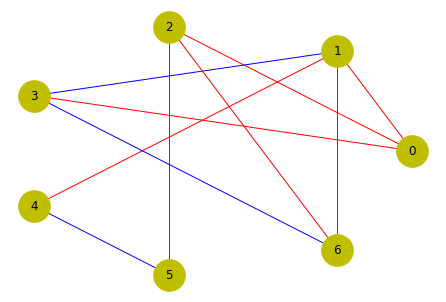

In [5]:
G = nx.Graph()
G.add_nodes_from(s)
for item in J_nn:
    G.add_edge(item[1],item[2],color='r' if (item[0]>0) else 'b',weight=item[0])

edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['weight'] for u,v in edges]
    
options = {
    'node_color': 'y',
    'node_size': 1000,
}
    
nx.draw(G,with_labels=True,pos=nx.circular_layout(G),edges=edges,edge_color=colors,width=weights,**options)

In this figure the red (blue) signifies a positive (negative) weight.

## Building the many-body Hamiltonian <a id='ed'></a>

In [6]:
# Loading the Pauli matrices

Id = sps.eye(2)
Sx = sps.csr_matrix(np.array([[0,1.+0.j],[1+0.j,0]]))
Sy = sps.csr_matrix(np.array([[0,-1.j],[1.j,0]]))
Sz = sps.csr_matrix(np.array([[1+0.j,0.],[0,-1+0.j]]))

In [7]:
def ham_general(L,static):
    ham_gen=np.zeros(shape=(2**L,2**L),dtype=np.complex)
    for item in static:
        string=item[0]
        for inside in item[1:len(item)]:
            for j in range(len(inside)):
                op_list=[Id]*L
                for k in range(len(string)):
                    if string[k]=='x':
                        op_list[inside[j][k+1]]=Sx
                    elif string[k]=='y':
                        op_list[inside[j][k+1]]=Sy
                    elif string[k]=='z':
                        op_list[inside[j][k+1]]=Sz
                #print(reduce(sps.kron,op_list).toarray())
                ham_gen += inside[j][0]*reduce(sps.kron,op_list).toarray()
    #            
    return ham_gen

In [8]:
hamiltonian = ham_general(L,static)

(e,u) = spslin.eigsh(hamiltonian, k=8, which='SA',return_eigenvectors=True)

Althogh the Hamiltonian matrix is fully diagonal, since we only have the $\sigma^z\sigma^z$ interaction, here we use the brute force method to get the eigenvalues.

### sneak peak in the eigenvalues

In [9]:
sorted_e=np.sort(e)

sorted_e,e

(array([-8., -8., -6., -6., -6., -6., -4., -4.]),
 array([-8., -8., -4., -6., -6., -6., -6., -4.]))

We see a two fold degenerate ground state and two fold degenerate excited state with excitation energy $\Delta\sim .015$. Obviously the two fold degeneracy is due to the $Z_2$ symmetry present in our system.

lets save our few low lying states in a $4\times 2^L$ dimensional array. Since scipy is not giving the sorted output, we sort the vectors bellow for better represeantion of the data.

In [10]:
vec_ed=np.ndarray(shape=(2**L,4),dtype=np.complex)

for i in range(4):
    print()
    vec_ed[:,i]=u[:,np.where(e == sorted_e[i])[0][0]]

In [11]:
def state_to_ampl_counts(vec, eps=1e-15):
    """Converts a statevector to a dictionary
    of bitstrings and corresponding amplitudes
    """
    qubit_dims = np.log2(vec.shape[0])
    if qubit_dims % 1:
        raise ValueError("Input vector is not a valid statevector for qubits.")
    qubit_dims = int(qubit_dims)
    counts = {}
    str_format = '0{}b'.format(qubit_dims)
    for kk in range(vec.shape[0]):
        val = vec[kk]
        if val.real**2+val.imag**2 > eps:
            counts[format(kk, str_format)] = val
    return counts

## Understading the ED result by converting it to $\sigma^z$ states

In [12]:
state_to_ampl_counts(vec_ed[:,0]),state_to_ampl_counts(vec_ed[:,1])

({'0111000': (-0.2637726868442919+0.5093103363427324j),
  '1000111': (-0.7826325243375836+0.24189518973799162j)},
 {'0111000': (-0.36710919657703933-0.713555989169082j),
  '1000111': (-0.1947735389929016+0.5640318755333557j)})

Clearly we see the two fold symmetric ground states, and the ED result is the symmetric and anti symmetric combinations of the two states. Furthermore we can now construct the states by hand and calculate the energies:

In [13]:
dictionary_gs=state_to_ampl_counts(vec_ed[:,0])

# dictionary={'0111': (0.6334855744612489+0.05418536095999862j),
#   '1000': (0.7717673443784631+0.011624962716153996j)}

states_gs=list(dictionary_gs.keys())
amplitudes_gs=np.array([dictionary_gs[item] for item in states_gs])

states_gs,amplitudes_gs

(['0111000', '1000111'],
 array([-0.26377269+0.50931034j, -0.78263252+0.24189519j]))

### define a function which gives the vector output for a z-order

In [14]:
def state_to_vec(string):
    length=len(string)
    list_local=[0.]*(2**length)
    value=0
    for j,index in enumerate(string):
        if index=='1':
            value += 2**(length-1-j)
    list_local[value]=1.
    return np.array(list_local)

def calculate_energy(vec,hamiltonian):
    energy=np.matmul(vec,np.matmul(hamiltonian,vec)).real
    return energy

In [15]:
# back calculate the energy of the obtained ground state

for state in states_gs:
    vec=state_to_vec(states_gs[0])
    print('for the state: %s the energy is %.9f'%(state,calculate_energy(vec,hamiltonian)))

for the state: 0111000 the energy is -8.000000000
for the state: 1000111 the energy is -8.000000000


## Excited states:

similarly we can find out the $\sigma^z$ order of the excitated state, remember there are two excited states, from the ED result they should be orthogonal to each other.

In [16]:
dictionary_es=state_to_ampl_counts(vec_ed[:,2])

states_es=list(dictionary_es.keys())
amplitudes_es=np.array([dictionary_es[item] for item in states_es])

states_es,amplitudes_es

(['0110000', '0111001', '1000110', '1001111'],
 array([-0.47768982+0.09410231j, -0.76850536+0.09087743j,
         0.05830945-0.24799059j, -0.30753191+0.06799118j]))

In [17]:
for state in states_es:
    vec=state_to_vec(states_es[0])
    energy=np.matmul(vec,np.matmul(hamiltonian,vec)).real
    print('for the state: %s the energy is %.9f'%(state,energy))

for the state: 0110000 the energy is -6.000000000
for the state: 0111001 the energy is -6.000000000
for the state: 1000110 the energy is -6.000000000
for the state: 1001111 the energy is -6.000000000


# finally visualizing the max-cut sollution

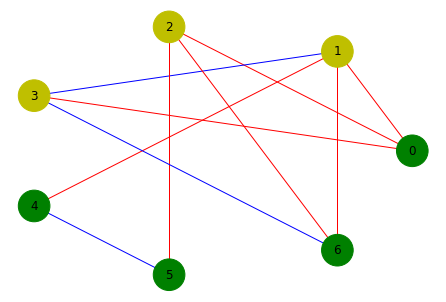

In [18]:
G = nx.Graph()
G.add_nodes_from(s)
for item in J_nn:
    G.add_edge(item[1],item[2],color='r' if (item[0]>0) else 'b',weight=item[0])

edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['weight'] for u,v in edges]
    
options = {'node_size': 1000,}

n_color=['g' if (node == '0') else 'y' for node in states_gs[0]]

nx.draw(G,node_color=n_color,with_labels=True,pos=nx.circular_layout(G),edges=edges,edge_color=colors,width=weights,**options)

### The other state with $Z_2$ symmetry

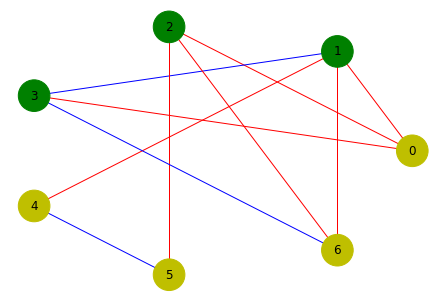

In [19]:
G = nx.Graph()
G.add_nodes_from(s)
for item in J_nn:
    G.add_edge(item[1],item[2],color='r' if (item[0]>0) else 'b',weight=item[0])

edges = G.edges()
colors = [G[u][v]['color'] for u,v in edges]
weights = [G[u][v]['weight'] for u,v in edges]
    
options = {'node_size': 1000,}

n_color=['g' if (node == '0') else 'y' for node in states_gs[1]]

nx.draw(G,node_color=n_color,with_labels=True,pos=nx.circular_layout(G),edges=edges,edge_color=colors,width=weights,**options)

Remember the fact that, red (blue) signifies the positive (negative) weight, in the above figure green (yellow) signifies $\sigma^z=0$ ($\sigma^z=1$). In the bellow figure, where we flip the 6th node, we get the first excited state.

# Another easier method

Since the Hamiltonian is diagonal, we can just use the `numpyp.diagonal` and `numpy.sort` to find out the all the eigenvalues.

In [20]:
diagonal=np.diagonal(hamiltonian)
assert(diagonal.shape[0]==2**L)

minimum=np.amin(diagonal)
np.where(diagonal == minimum)
sorted_diagonal=np.sort(diagonal)

sorted_diagonal;

In [21]:
energy=sorted_diagonal[0]
arr=np.where(diagonal == energy)

gs_1=str(format(arr[0][0],'0{}b'.format(L)))
gs_2=str(format(arr[0][1],'0{}b'.format(L)))

print('The GS are: ',gs_1,'&',gs_2)

The GS are:  0111000 & 1000111


We clearly see that all the low lying eigenstate are very easy to calculate using this method.

# Now we will try to solve the same problem using QAOA <a id='qasm'></a>

QAOA method is a <a href='https://arxiv.org/abs/1411.4028'>variational method</a>, which is in turn inspired by the <a href='https://arxiv.org/abs/quant-ph/0001106'>adiabatic quantum computation</a>. We alternatively apply rotation with respect to the Hamiltonian ($\mathcal{H}$) and a mixer term (uniform x-field: $B=\sum_i\sigma^x_i$) with the angles $\gamma$ and $\beta$ respectively. After computing the energy of the final state at the end of the rotation, using the Hamiltonian, we get 

$$F(\overrightarrow{\beta},\overrightarrow{\gamma})\equiv<\psi{(\overrightarrow{\beta},\overrightarrow{\gamma})}|\mathcal{H}|\psi{(\overrightarrow{\beta},\overrightarrow{\gamma})}>$$

With $|\psi{(\overrightarrow{\beta},\overrightarrow{\gamma})}> =  \left(e^{-i\beta_p B}e^{-i\gamma_p H}\right)\cdots \left(e^{-i\beta_1 B}e^{-i\gamma_1 C}\right) H^{\otimes n} |0>$. Next we optimize the rotation angle so that the energy of the final state is minimized, and we get a optimal set of $(\overrightarrow{\beta}^*,\overrightarrow{\gamma}^*)$, and the supposedly GS of the system. Since the optimization is done in a classical computer, while the rotation is performed in quantum computer, this is called hybrid solver, which is claimed to be useful for the current noisy quantum computers available today. Thus the current era of quantum computing is called the era of <a href='https://quantum-journal.org/papers/q-2018-08-06-79/'>noisy intermediate-scale quantum (NISQ)</a> computing.

The claim is if we increase this alternate layer, we get more closer to the GS.

This is the full circuit, with we will now choose, $p=1~;~\beta=\text{x-field angle} (B);~\gamma=\text{Hamiltonian angle}(\mathcal{H})$

<img src="./qaoa.jpeg" width="700" height="700">

Here, H is the Hadamard gate, and $\mathcal{H}$ is the Hamiltonian of interest.

In [22]:
# have a look into the static matrix

static;

## Redefining the Hamiltonian along with the qiskit convention

In [23]:
def inv_ham_general(L,static):
    ham_gen=np.zeros(shape=(2**L,2**L),dtype=np.complex)
    for item in static:
        string=item[0]
        for inside in item[1:len(item)]:
            for j in range(len(inside)):
                op_list=[Id]*L
                for k in range(len(string)):
                    if string[k]=='x':
                        op_list[L-1-inside[j][k+1]]=Sx
                    elif string[k]=='y':
                        op_list[L-1-inside[j][k+1]]=Sy
                    elif string[k]=='z':
                        op_list[L-1-inside[j][k+1]]=Sz
                ham_gen += inside[j][0]*reduce(sps.kron,op_list).toarray()
    #            
    return ham_gen

In [24]:
def ham_rot(s, static, gamma):
    L=len(s)
    qc=QuantumCircuit(L,L)
    for item in static:
        opr=item[0]
        adjacent=item[1]
        if opr=='zz':
            for element in adjacent:
                strength=element[0]
                nodes=element[1:len(element)]
                qc.cx(nodes[0],nodes[1])
                qc.rz(2*gamma*strength,nodes[1])
                qc.cx(nodes[0],nodes[1])
    #   
    return qc

In [25]:
qc = ham_rot(s, static, np.pi/3)
qc.draw()

»
q_0: ──■────────────────■────■────────────────■────■─────────────────────■──»
     ┌─┴─┐┌──────────┐┌─┴─┐  │                │    │                     │  »
q_1: ┤ X ├┤ RZ(2π/3) ├┤ X ├──┼────────────────┼────┼─────────────────────┼──»
     └───┘└──────────┘└───┘┌─┴─┐┌──────────┐┌─┴─┐  │                     │  »
q_2: ──────────────────────┤ X ├┤ RZ(2π/3) ├┤ X ├──┼────■────────────────┼──»
                           └───┘└──────────┘└───┘┌─┴─┐  │  ┌──────────┐┌─┴─┐»
q_3: ────────────────────────────────────────────┤ X ├──┼──┤ RZ(2π/3) ├┤ X ├»
                                                 └───┘  │  └──────────┘└───┘»
q_4: ───────────────────────────────────────────────────┼───────────────────»
                                                      ┌─┴─┐┌──────────┐     »
q_5: ─────────────────────────────────────────────────┤ X ├┤ RZ(2π/3) ├─────»
                                                      └───┘└──────────┘     »
q_6: ───────────────────────────────────────────────────────────────────────»
                                                                            »
c: 7/═══════════════════════════════════════════════════════════════════════»
                                                                            »
«                                                                        »
«q_0: ───────────────────────────────────────────────────────────────────»
«                                                                        »
«q_1: ───────■─────────────────■────■────────────────■────■──────────────»
«            │                 │    │                │    │              »
«q_2: ──■────┼─────────────────┼────┼────────────────┼────┼──────────────»
«       │  ┌─┴─┐┌───────────┐┌─┴─┐  │                │    │              »
«q_3: ──┼──┤ X ├┤ RZ(-2π/3) ├┤ X ├──┼────────────────┼────┼──────────────»
«       │  └───┘└───────────┘└───┘┌─┴─┐┌──────────┐┌─┴─┐  │              »
«q_4: ──┼─────────────────────────┤ X ├┤ RZ(2π/3) ├┤ X ├──┼───────■──────»
«     ┌─┴─┐                       └───┘└──────────┘└───┘  │     ┌─┴─┐    »
«q_5: ┤ X ├───────────────────────────────────────────────┼─────┤ X ├────»
«     └───┘                                             ┌─┴─┐┌──┴───┴───┐»
«q_6: ──────────────────────────────────────────────────┤ X ├┤ RZ(2π/3) ├»
«                                                       └───┘└──────────┘»
«c: 7/═══════════════════════════════════════════════════════════════════»
«                                                                        »
«                                                                         
«q_0: ────────────────────────────────────────────────────────────────────
«                                                                         
«q_1: ───────────────■────────────────────────────────────────────────────
«                    │                                                    
«q_2: ───────────────┼─────────■────────────────■─────────────────────────
«                    │         │                │                         
«q_3: ───────────────┼─────────┼────────────────┼────■─────────────────■──
«                    │         │                │    │                 │  
«q_4: ───────────────┼────■────┼────────────────┼────┼─────────────────┼──
«     ┌───────────┐  │  ┌─┴─┐  │                │    │                 │  
«q_5: ┤ RZ(-2π/3) ├──┼──┤ X ├──┼────────────────┼────┼─────────────────┼──
«     └───────────┘┌─┴─┐└───┘┌─┴─┐┌──────────┐┌─┴─┐┌─┴─┐┌───────────┐┌─┴─┐
«q_6: ─────────────┤ X ├─────┤ X ├┤ RZ(2π/3) ├┤ X ├┤ X ├┤ RZ(-2π/3) ├┤ X ├
«                  └───┘     └───┘└──────────┘└───┘└───┘└───────────┘└───┘
«c: 7/════════════════════════════════════════════════════════════════════
«

In [26]:
def x_field_rot(s, static, beta):
    L = len(s)
    qc = QuantumCircuit(L,L)
    for n in s:
        qc.rx(2*beta, n)
    return qc

qc = x_field_rot(s, static, np.pi/3)
qc.draw()

┌──────────┐
q_0: ┤ RX(2π/3) ├
     ├──────────┤
q_1: ┤ RX(2π/3) ├
     ├──────────┤
q_2: ┤ RX(2π/3) ├
     ├──────────┤
q_3: ┤ RX(2π/3) ├
     ├──────────┤
q_4: ┤ RX(2π/3) ├
     ├──────────┤
q_5: ┤ RX(2π/3) ├
     ├──────────┤
q_6: ┤ RX(2π/3) ├
     └──────────┘
c: 7/════════════

# defining the QAOA circuit (QASM)

In [27]:
def qaoa_circuit_qasm(s, static, beta, gamma):
    assert(len(beta) == len(gamma))
    p = len(beta) # infering number of QAOA steps from the parameters passed
    L=len(s)
    qc = QuantumCircuit(L,L)
    # first, apply a layer of Hadamards
    qc.h(range(L))
    # second, apply p alternating operators
    for k in range(p):
        qc=qc+ham_rot(s, static, gamma[k])
        qc=qc+x_field_rot(s, static, beta[k])
    qc.barrier(range(L))
    # measure at the end
    qc.measure(range(L), range(L))
    return qc

def compute_ising_energy_qasm(counts, inv_hamiltonian):
    energy = 0
    total_counts = 0
    for meas, meas_count in counts.items():              # meas and meas_count are the state and freq
        vec=state_to_vec(str(meas))
        energy_vec=calculate_energy(vec,inv_hamiltonian)
        energy += energy_vec * meas_count
        total_counts += meas_count                       # energy is total energy of all the states
    return energy / total_counts                         # total_counts is total number of sampling

def get_black_box_objective_qasm(s, static, p, inv_hamiltonian,energy_qasm):
    backend = Aer.get_backend('qasm_simulator')
    def f(theta):
        # let's assume first half is betas, second half is gammas
        # theta is a 2*p length array, first 'p' entries are gamma and rest are beta
        beta = theta[:p]
        gamma = theta[p:]
        qc = qaoa_circuit_qasm(s, static, beta, gamma)
        counts = execute(qc, backend,shots=1024, seed_simulator=100).result().get_counts()
        # return the energy
        ener=compute_ising_energy_qasm(counts, inv_hamiltonian)
        energy_qasm.append(ener)
        return ener
    return f

# we are choosing p number of layers

p=int(1.5*L)

energy_qasm=[]
np.random.seed(123)
init_point = np.random.rand(2*p)
init_point
inv_hamiltonian=inv_ham_general(L,static)
obj = get_black_box_objective_qasm(s, static, p, inv_hamiltonian,energy_qasm)
# We are going to limit the number of iterations to 5000
# constraint=
res_qasm = minimize(obj, init_point, method='COBYLA', options={'maxiter':2500, 'disp': False}, tol=.01)

/Users/animeshnanda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  # Remove the CWD from sys.path while we load stuff.
/Users/animeshnanda/anaconda3/lib/python3.7/site-packages/qiskit/circuit/quantumcircuit.py:869: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  return self.combine(rhs)


In [28]:
res_qasm

     fun: -2.912109375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 129
  status: 1
 success: True
       x: array([ 1.62581473,  1.13939253, -0.04882855,  0.56411243,  0.69928003,
        0.45179601,  0.86905642,  0.65596773,  0.45480804,  0.41815255,
        0.27309423,  0.94160877,  0.5431782 , -0.0548291 ,  0.32107375,
        0.80896905,  0.1727937 ,  0.30700319,  1.53318488,  0.7742002 ])

# execute the circuit with optimal angles

In [29]:
shots=2048

def get_qaoa_circuit_qasm(s, static, beta, gamma):
    assert(len(beta) == len(gamma))
    p = len(beta) # infering number of QAOA steps from the parameters passed
    L=len(s)
    qc = QuantumCircuit(L,L)
    # first, apply a layer of Hadamards
    qc.h(range(L))
    # second, apply p alternating operators
    for k in range(p):
        qc=qc+ham_rot(s, static, gamma[k])
        qc=qc+x_field_rot(s, static, beta[k])
    qc.measure(range(L), range(L))
    return qc

def invert_counts(counts):
    return {k[::-1]:v for k, v in counts.items()}

backend = Aer.get_backend('qasm_simulator')

optimal_theta = res_qasm['x']
qc = get_qaoa_circuit_qasm(s, static, optimal_theta[:p], optimal_theta[p:])
counts = invert_counts(execute(qc, backend,shots=shots).result().get_counts())

In [30]:
# deleting the results with probability less than 2%

eps=int(.02*2048)
entries=list(counts)

for entry in entries:
    if counts[entry]<=eps:
        del counts[entry]
        
counts

{'0111000': 191,
 '0001111': 77,
 '1110000': 74,
 '0111010': 89,
 '1000101': 94,
 '0011101': 48,
 '0000111': 44,
 '1000111': 169}

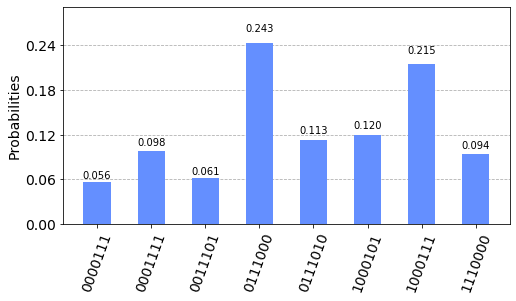

In [31]:
plot_histogram(counts,figsize=(8,4))

In [32]:
# remembering the ED result

for state in states_gs:
    vec=state_to_vec(states_gs[0])
    print('for the state: %s the energy is %.9f'%(state,calculate_energy(vec,hamiltonian)))

for the state: 0111000 the energy is -8.000000000
for the state: 1000111 the energy is -8.000000000


# Defining the QAOA circuit (State Vector) <a id='state'></a>

In [33]:
def get_qaoa_circuit_sv(s, static, beta, gamma):
    assert(len(beta) == len(gamma))
    p = len(beta) # infering number of QAOA steps from the parameters passed
    L=len(s)
    qc = QuantumCircuit(L,L)
    # first, apply a layer of Hadamards
    qc.h(range(L))
    # second, apply p alternating operators
    for k in range(p):
        qc=qc+ham_rot(s, static, gamma[k])
        qc=qc+x_field_rot(s, static, beta[k])
    # no measurement in the end!
    return qc

def compute_ising_energy_sv(sv_old,inv_hamilton):
    """Compute objective from statevector
    For large number of qubits, this is slow. 
    """
    #sv=np.flip(sv_old)
    sv=np.array(sv_old)
    adjsv=np.conjugate(sv)
    mult=np.matmul(inv_hamilton, sv)
    ener=np.matmul(adjsv,mult)
    return ener.real

def get_black_box_objective_sv(s, static, p, inv_hamilton, energy_sv):
    backend = Aer.get_backend('statevector_simulator')
    def f(theta):
        # let's assume first half is betas, second half is gammas
        beta = theta[:p]
        gamma = theta[p:]
        qc = get_qaoa_circuit_sv(s, static, beta, gamma)
        sv = execute(qc, backend).result().get_statevector()  # the sv is np.array with complex entries
        # return the energy
        ener=compute_ising_energy_sv(sv, inv_hamilton)
        energy_sv.append(ener)
        return ener, energy_sv
    return f

# we are choosing p number of layers

p=L

energy_sv=[]
np.random.seed(123)
init_point = np.random.rand(2*p)
init_point
inv_hamiltonian=inv_ham_general(L,static)
obj = get_black_box_objective_sv(s, static, p, inv_hamiltonian,energy_sv)
# We are going to limit the number of iterations to 5000
# constraint=
res_sv = minimize(obj, init_point, method='COBYLA', options={'maxiter':2500, 'disp': False}, tol=.01)

In [34]:
res_sv

     fun: -7.092067078195671
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 522
  status: 1
 success: True
       x: array([ 2.11010485,  0.81214942,  0.37092929,  0.79052505,  1.06475011,
        0.38723691,  0.91533577,  0.03857371,  0.21351301,  0.27225311,
        0.15441018,  0.40341619,  0.53887384, -0.11216017])

## Sampling the circuit with the optimized $\gamma~\&~\beta$'s

In [35]:
def get_qaoa_circuit_qasm(s, static, beta, gamma):
    assert(len(beta) == len(gamma))
    p = len(beta) # infering number of QAOA steps from the parameters passed
    L=len(s)
    qc = QuantumCircuit(L,L)
    # first, apply a layer of Hadamards
    qc.h(range(L))
    # second, apply p alternating operators
    for k in range(p):
        qc=qc+ham_rot(s, static, gamma[k])
        qc=qc+x_field_rot(s, static, beta[k])
    qc.measure(range(L), range(L))
    return qc

backend = Aer.get_backend('qasm_simulator')

optimal_theta = res_sv['x']
qc = get_qaoa_circuit_qasm(s, static, optimal_theta[:p], optimal_theta[p:])
counts = invert_counts(execute(qc, backend,shots=2048).result().get_counts())
counts;

In [36]:
# deleting the results with probability less than 2%

eps=int(.02*2048)
entries=list(counts)

for entry in entries:
    if counts[entry]<=eps:
        del counts[entry]
        
counts

{'0111001': 84,
 '1000111': 781,
 '1000110': 78,
 '1001111': 100,
 '0111000': 689,
 '0110000': 73}

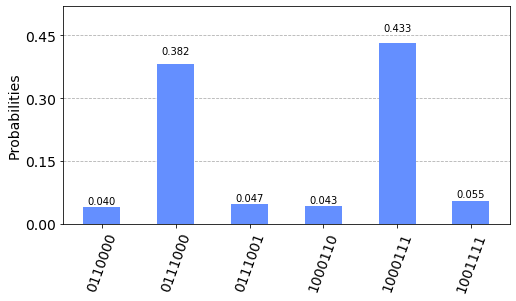

In [37]:
plot_histogram(counts,figsize=(8,4))

In [38]:
# remembering the ED result

# back calculate the energy of the obtained ground state

for state in states_gs:
    vec=state_to_vec(states_gs[0])
    print('for the state: %s the energy is %.9f'%(state,calculate_energy(vec,hamiltonian)))

for the state: 0111000 the energy is -8.000000000
for the state: 1000111 the energy is -8.000000000


# Comparing the results from two different simulators:

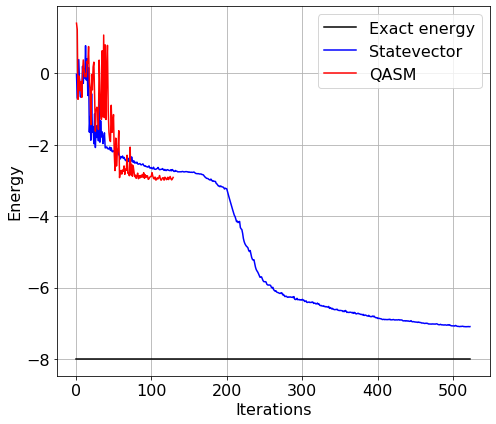

In [39]:
ms=6
x_sv=np.arange(1,len(energy_sv)+1)
x_qasm=np.arange(1,len(energy_qasm)+1)
exact=sorted_diagonal[0].real

plt.figure(figsize=(7,6))
plt.plot(np.linspace(1,max(len(x_sv),len(x_qasm)),2),[exact,exact],'k-',label='Exact energy')
plt.plot(x_sv,energy_sv,'b-',markersize=ms,label='Statevector')
plt.plot(x_qasm,energy_qasm,'r-',markersize=ms,label='QASM')
plt.xlabel('Iterations',fontsize=16)
plt.ylabel('Energy',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid()
plt.tight_layout()
plt.show()

In summary we see that, although the ground state energy is not predicted well in the case of QAOA, the ground state configuration for the lowest energies are predicted correctly.

* In this problem I have used 10 (7) layers for the QASM (statevector) simulation. There is the interesting question about what is the relation between L and p in general.

* In the case of nearest neighbour interaction with a translation symmetry I have noticed that the system is predicting the GS energy pretty correctly, sometimes it can match with the results from exact diagonalization in the statevector. Then the question is wh ythe performance is poor in random bond long distance interaction scenario.

<a href='#top'>Go to the top</a>